<a href="https://colab.research.google.com/github/yuvi-s64/YuviN-DataScience-GenAI-Submissions/blob/main/7_01_convolutional_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=1xqQczl0FG-qtNA2_WQYuWePW9oU8irqJ)

# 7.01 Convolutional Neural Networks
This tutorial will start by walking through a custom-built CNN in PyTorch. We will be working with a chest x-ray set from Kaggle ([here](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)) where we are predicting whether a paitent has pneumonia or not.

To get the data we need an API key from Kaggle. Set up an account (if you haven't got one already) and then click on your avatar in the top right and "Account" from the dropdown menu. Scroll down the page and you'll find a button to "Create New API Token". This downloads an API key to your PC which you can upload here.

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yuvis64","key":"fc4cf4df6878b31bf6e4497c8657a325"}'}

Next we need to move this to a folder called kaggle as this is where Colab will look to find the API key. This has been written as Linux commands as we are doing this directly on the underlying (virtual) machine not within Python. Linux commands start with a "!" in Colab. Linux is out of scope for the module so we won't go into detail on the code.

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

## Data Extraction
Now you can download the data. The following can be used for any Kaggle dataset. When you are on the dataset page click the three vertical dots on the right and select "Copy API command". This gives you code that looks like below (but add a "!" at the start):

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:31<00:00, 239MB/s]
100% 2.29G/2.29G [00:31<00:00, 77.8MB/s]


This has added the data as a zip folder. We can unzip it and create a new folder (Linux again):

In [4]:
!unzip chest-xray-pneumonia.zip -d chest-xray-pneumonia

Streaming output truncated to the last 5000 lines.
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0442-

## Training, Test and Validation Split
This data comes in three sets, `train`, `val` (validation) and `test`. We have seen two of these before, but `val` is new.

Because deep learning effectively uses _epochs_ as a hyperparameter, and the length of time we train the model will impact under- and over-fitting, we want to measure performance every $x$ number of epochs. As with hyperparameter tuning in the classical space, we don't want to use `test` to check perofmance as this is cheating and can cause _data leakage_ (the model being able to see the test data). We also don't want to use the training data as this can't measure overfitting (overfitting can only be measured on unseen data). We could do cross validation but this will be very expensive to do over many epochs (i.e. it will take ages). So instead we will split our data an extra time and create a `val` set. This will be used to measure performance over epochs, but also can be used to tune other hyperparameters.

For ease we will create some variables to store the path to the directories:

In [5]:
train_dir = "/content/chest-xray-pneumonia/chest_xray/train"
test_dir = "/content/chest-xray-pneumonia/chest_xray/test"
val_dir = "/content/chest-xray-pneumonia/chest_xray/val"

## Data Preparation
Now we can add a generator to prepare out data. This data will perform basic cleaning operations on the data and feed it into the model.

The three tasks we will do are:
* `ToTensor()` changes the data into tensor format as before.
* `Resize()` changes the size of the images to something smaller (to make computations faster and easier).
* `Normalize()` (sic) effectively normalises the data as we have done previously with min-max or standardisation.

For images normalisation is slighltly different as we are working with RGB pixels, meaning each data item is a red score between 0 (no red) and 255 (red); a green score between 0 (no green) and 255 (green); and a blue score between 0 (no blue) and 255 (blue). This means if a pixel is stored as:
* RGB = [0,255,0] the pixel colour will be green.
* RGB = [255,0,0] the colour will be red.
* RGB = [0,0,0] the colour will be white.
* RGB = [255,255,255] the colour will be black.
* RGB = [255,0,255] the colour will be purple.
* And so on.

Because we are not scaling based on mean or max values in our data, all our data has the same scale, we apply the same transformation to all the datasets.

We do these transformations for each of our datasets (`train`, `val` and `test`) and then create a `DataLoader` to move the data into the model. First we split into batches of 64 items per batch. We _shuffle_ our training data, meaning we put the data into random order in case there are biases in how it has been saved that would then be present in our batches. `pin_memory` is used just to make things a little faster as the Colab environment is slightly underpowered.

In [6]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Define data transformations
train_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Resize((32, 32)),  # Resize images (adjust size as needed)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalization
])

val_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets and apply transfomrations
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Create data loaders
batch_size = 64  # Adjust batch size as needed (hyperparameter!)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

## Convolutional Neural Network
Now we can build our model.

We will use some of the layers we saw in the lecture, plus a few others. To summarise the model we have, in this order:
* A convolutional layer (`Conv2d`) working in 3 dimensions (RGB), with 16 filters it finds (patterns it looks for) which will be within 3x3 (3 pixels wide and 3 pixels deep) squares.
* A batch normalisation layer (`BatchNorm2d`) to normalise based on the batch mean and standard deviation.
* A pooling layer (`MaxPool2d`) that reduces the size of the ouputs by taking the maximum value only from each 2x2 square, jumping (stride) 2 pixels each time. We pad the outer layer of the image with an additional set of zeros so that we can ensure that patterns near the outside of the image are scanned.
* Another convolutional layer with 16 3x3 filters, now working across the 16 outputs of the pooling layer.
* Another normalisation layer.
* Another pooling layer identical to before.
* A flatten layer (`Flatten`) which converts the various matrices from the previous layer to a long vector (i.e. a long list of 576 values).
* A linear layer (`Linear`) which is a fully connected neural network layer (where each layer is linear regression with ReLU activation). This takes us from 576 values to 24.
* A dropout layer (`Dropout`) which randomly turns off neurons during training to prevent overfitting.
* A final linear layer with sigmoid activation (i.e. logistic regression) to convert the previous outputs to binary classification.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PneumoniaCNN(nn.Module):
    def __init__(self):
        super(PneumoniaCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3) # conv layer with 16 3x3 filters
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # maxpool to 2x2 filters, pad with 0
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3) # conv layer with 16 3x3 filters
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # maxpool to 2x2 filters, pad with 0
        self.flatten = nn.Flatten() # flatten layer
        self.fc1 = nn.Linear(576, 24) # linear layer with 24 neurons
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(24, 1) # binary classification so 1x neuron

    def forward(self, x):
        x = F.relu(self.conv1(x)) # convolution with ReLU
        x = self.bn1(x)
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.flatten(x) # Use flatten layer
        x = F.relu(self.fc1(x)) # linear layer with ReLU
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x)) # Sigmoid for binary classification
        return x

cnn = PneumoniaCNN()
cnn

PneumoniaCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=576, out_features=24, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=24, out_features=1, bias=True)
)

To complete our model let's specify the loss function and optimiser. We will use a slightly different optimiser than before - [Adam](https://arxiv.org/abs/1412.6980). You can read more from the link if you want to. We will also start with a learning rate of 0.001 (0.1%) and will reduce this number by 0.0005 every epoch. This means that as the training goes on we will take smaller and smaller steps so we can be sure we don't miss the optimal model (the one with the lowest loss).

In [8]:
# Define loss function and optimiser
import torch.optim as optim

criterion = nn.BCELoss() # Binary Cross-Entropy Loss for binary classification
optimiser = optim.Adam(cnn.parameters(), lr=0.001, weight_decay=0.0005) # Adam optimizer
# we add a weight decay parameter to reduce the learning rate each epoch

Let's see how many parameters this is:

In [9]:
# Move model to device
from torchsummary import summary

# Move data to GPU to get summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = cnn.to(device)

summary(cnn, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
       BatchNorm2d-2           [-1, 16, 30, 30]              32
         MaxPool2d-3           [-1, 16, 15, 15]               0
            Conv2d-4           [-1, 16, 13, 13]           2,320
       BatchNorm2d-5           [-1, 16, 13, 13]              32
         MaxPool2d-6             [-1, 16, 6, 6]               0
           Flatten-7                  [-1, 576]               0
            Linear-8                   [-1, 24]          13,848
           Dropout-9                   [-1, 24]               0
           Linear-10                    [-1, 1]              25
Total params: 16,705
Trainable params: 16,705
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.30
Params size (MB): 0.06
Estimated Tot

~17k parameters to learn! We better get busy:

We are going to apply _early stopping_, which is a new idea. Because we might overfit by running too many epochs, we will set up to autoamtically stop if the performance on validation doesn't improve after 5 epochs (the number 5 is effectively a hyperparameter we will call our _patience_). I.e. if epoch #6 give us a our best score, we then have until epoch #11 to get a better score or the training automatically stops.

In [ ]:
# Early stopping parameters
patience = 5 # how many times we accept no improvement in val performance before early stopping
best_val_loss = float('inf') # keep track of the best loss value
epochs_no_improve = 0 # start the count at 0

# empty lists to store losses for visualisation at the end
train_losses = []
val_losses = []

# Training loop
num_epochs = 500  # Arbitrarily high number - early stopping will end before this

# Run on GPU if avaialble
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For loop for training
for epoch in range(num_epochs):
    cnn.train() # switch to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        # add images and label in batch to the GPU
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)  # Convert labels to float and add dimension
        cnn = cnn.to(device) # Pass model to GPU as well

        optimiser.zero_grad() # reset the optimiser to start optimisation again

        # run the images through the model
        outputs = cnn(images)
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() # backpropogate
        optimiser.step() # update parameters
        running_loss += loss.item() # keep track of loss for visualisation

    # store losses for visualisation
    train_losses.append(running_loss/len(train_loader)) # average loss

    # Validation
    cnn.eval()
    val_loss = 0.0
    all_preds = [] # holder for predictions as 0 or 1
    all_labels = [] # compare with labels
    with torch.no_grad(): # not update/backpropogation
      for images, labels in val_loader:
          # add images and label in batch to the GPU
          images = images.to(device)
          labels = labels.to(device).float().unsqueeze(1)
          cnn = cnn.to(device) # Pass model as well

          # run the images through the model
          outputs = cnn(images)
          loss = criterion(outputs, labels) # calculate loss
          val_loss += loss.item() # keep track of loss for visualisation

    # store losses and recall for visualisation
    val_losses.append(val_loss/len(val_loader)) # average loss

    # Early stopping
    if val_loss < best_val_loss: # is this better than previous record?
        best_val_loss = val_loss # if so set as new best
        epochs_no_improve = 0 # make the no improve counter zero again
    else:
        epochs_no_improve += 1 # otherwise increase the count by one

    train_loss_rnd = round(running_loss / len(train_loader), 4) # avg train loss
    val_loss_rnd = round(val_loss / len(val_loader), 4) # avg val loss

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss_rnd}, Validation Loss: {val_loss_rnd}")


    if epochs_no_improve == patience: # if epochs without improvement is at the patience level
        print("Early stopping triggered.")
        break # end the training


Epoch [1/500], Training Loss: 0.1104, Validation Loss: 1.8436


## Results
Let's visualise the results:

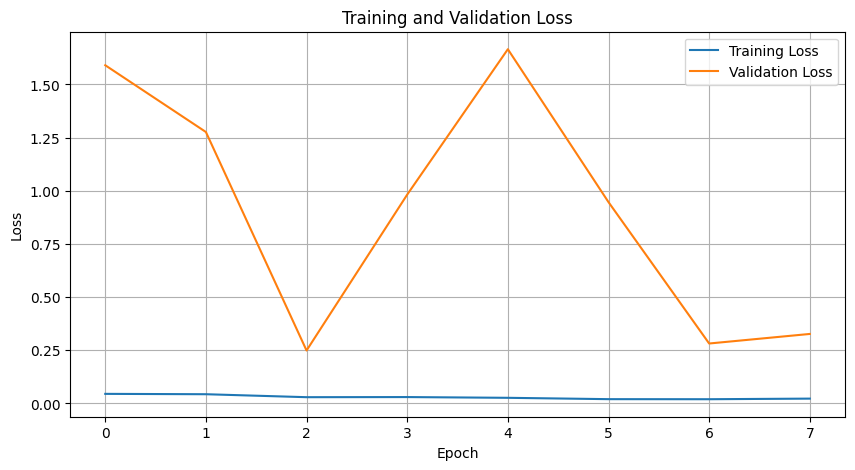

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

We can see loss on the training set has steadily improved. On the validation set its a bit more "bouncey" but then that's not a big set of images. It looks like our best performance was around 2 or 6 epochs. (Note, your results may change if you run it due to how we randomly split the data and so on). Let's see how we do on test:

In [ ]:
# Evaluation on the test set
from sklearn.metrics import recall_score

cnn.eval()
test_loss = 0.0
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predicted_labels = (outputs > 0.5).float()  # Convert probabilities to binary predictions
        correct_predictions += (predicted_labels == labels).sum().item()
        total_samples += labels.size(0)

test_loss_rnd = round(test_loss / len(test_loader), 4)
test_recall = round(recall_score(labels.cpu(), predicted_labels.cpu()), 4)

print(f"Test Loss: {test_loss_rnd}")
print(f"Test Recall: {test_recall}")

Test Loss: 1.1935
Test Recall: 0.9792


98% recall and relatively small loss (cross entropy) - again this may change if you run again but should be around these numbers. Our model seems to do pretty well ... but, would it be better if we changed some of the architecture or the batch size? Feel free to play a bit more if you want to!